# Setup Persiapan (Load data + sanity checks)

In [1]:
import os, json, gc
import numpy as np
import pandas as pd
from pathlib import Path

PREPROC_ROOT = Path("/kaggle/input/network-intrusion-detection-preprocessing")
FINAL_DIR = PREPROC_ROOT / "artifacts_final"

assert FINAL_DIR.exists(), f"FINAL_DIR tidak ditemukan: {FINAL_DIR}"
print("FINAL_DIR:", FINAL_DIR)
print("Files:", sorted([p.name for p in FINAL_DIR.iterdir()]))

FINAL_DIR: /kaggle/input/network-intrusion-detection-preprocessing/artifacts_final
Files: ['X_train.parquet', 'X_val.parquet', 'dataset_manifest.json', 'feature_names.json', 'label_encoder.json', 'y_train.npy', 'y_val.npy']


In [2]:
X_train_path = FINAL_DIR / "X_train.parquet"
X_val_path   = FINAL_DIR / "X_val.parquet"
y_train_path = FINAL_DIR / "y_train.npy"
y_val_path   = FINAL_DIR / "y_val.npy"

X_train = pd.read_parquet(X_train_path)
X_val   = pd.read_parquet(X_val_path)
y_train = np.load(y_train_path)
y_val   = np.load(y_val_path)

with open(FINAL_DIR / "label_encoder.json", "r") as f:
    le = json.load(f)

with open(FINAL_DIR / "feature_names.json", "r") as f:
    feature_names = json.load(f)

print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train:", y_train.shape, "y_val:", y_val.shape)
print("n_classes:", len(le["classes"]))

X_train: (90129, 196) X_val: (20910, 196)
y_train: (90129,) y_val: (20910,)
n_classes: 8


In [3]:
# feature alignment check
assert X_train.shape[1] == len(feature_names), "Jumlah feature tidak cocok dengan feature_names.json"
assert list(X_train.columns) == feature_names, "Urutan kolom X_train tidak sama dengan feature_names.json"
assert list(X_val.columns) == feature_names, "Kolom X_val tidak sama dengan X_train"

# NaN / inf check
def check_nan_inf(df, name):
    nan_cnt = int(df.isna().sum().sum())
    inf_cnt = int(np.isinf(df.to_numpy()).sum())
    print(f"{name}: NaN={nan_cnt}, Inf={inf_cnt}")
    assert inf_cnt == 0, f"{name} mengandung Inf!"
    # NaN seharusnya 0 karena sudah imputasi P4
    if nan_cnt > 0:
        print("⚠️ Warning: masih ada NaN. Contoh kolom NaN terbesar:")
        display(df.isna().mean().sort_values(ascending=False).head(10))

check_nan_inf(X_train, "X_train")
check_nan_inf(X_val, "X_val")

# label check
assert y_train.ndim == 1 and y_val.ndim == 1
assert y_train.min() >= 0 and y_train.max() < len(le["classes"])
assert y_val.min() >= 0 and y_val.max() < len(le["classes"])

print("✅ Sanity checks passed.")

X_train: NaN=0, Inf=0
X_val: NaN=0, Inf=0
✅ Sanity checks passed.


In [4]:
from collections import Counter

train_counts = Counter(y_train.tolist())
val_counts   = Counter(y_val.tolist())

# show top-10 and bottom-10
classes = le["classes"]
train_dist = pd.DataFrame({
    "class_id": list(train_counts.keys()),
    "class_name": [classes[i] for i in train_counts.keys()],
    "train_count": list(train_counts.values()),
}).sort_values("train_count", ascending=False)

val_dist = pd.DataFrame({
    "class_id": list(val_counts.keys()),
    "class_name": [classes[i] for i in val_counts.keys()],
    "val_count": list(val_counts.values()),
}).sort_values("val_count", ascending=False)

display(train_dist.head(10))
display(train_dist.tail(10))

,class_id,class_name,train_count
1,4,normal,48321
2,2,neptune,29752
7,1,ipsweep,2805
5,6,satan,2401
4,5,portsweep,2269
6,7,smurf,2104
3,0,Denial of Service Attack,1320
0,3,nmap,1157


,class_id,class_name,train_count
1,4,normal,48321
2,2,neptune,29752
7,1,ipsweep,2805
5,6,satan,2401
4,5,portsweep,2269
6,7,smurf,2104
3,0,Denial of Service Attack,1320
0,3,nmap,1157


In [5]:
X_train_np = X_train.to_numpy(dtype=np.float32, copy=False)
X_val_np   = X_val.to_numpy(dtype=np.float32, copy=False)

print("X_train_np:", X_train_np.shape, X_train_np.dtype)
print("X_val_np:", X_val_np.shape, X_val_np.dtype)

X_train_np: (90129, 196) float32
X_val_np: (20910, 196) float32


# M1 — XGBoost Training

In [6]:
try:
    import xgboost as xgb
    print("xgboost version:", xgb.__version__)
except Exception as e:
    print("xgboost not available:", e)
    raise

xgboost version: 3.1.0


In [7]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

def eval_multiclass(y_true, y_pred, label_names=None):
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    per_class_recall = {k: v["recall"] for k,v in rep.items() if k not in ["accuracy","macro avg","weighted avg"]}
    return macro_f1, weighted_f1, per_class_recall, rep

In [8]:
# Pastikan Anda sudah punya:
# X_train_np, X_val_np, y_train, y_val, le (dari setup)

dtrain = xgb.DMatrix(X_train_np, label=y_train)
dval   = xgb.DMatrix(X_val_np, label=y_val)

n_classes = len(le["classes"])
print("n_classes:", n_classes)

n_classes: 8


In [9]:
params = {
    "objective": "multi:softprob",
    "num_class": n_classes,
    "eval_metric": "mlogloss",
    "tree_method": "hist",       
    "learning_rate": 0.05,
    "max_depth": 8,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "random_state": 42,
}

num_boost_round = 5000
early_stopping_rounds = 100

watchlist = [(dtrain, "train"), (dval, "val")]

In [10]:
evals_result = {}

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=early_stopping_rounds,
    evals_result=evals_result,
    verbose_eval=100
)

[0]	train-mlogloss:1.67311	val-mlogloss:1.65826
[100]	train-mlogloss:0.01949	val-mlogloss:0.02467
[200]	train-mlogloss:0.00736	val-mlogloss:0.01555
[279]	train-mlogloss:0.00572	val-mlogloss:0.01622


In [11]:
val_proba = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))
val_pred = np.argmax(val_proba, axis=1)

macro_f1, weighted_f1, per_class_recall, rep = eval_multiclass(y_val, val_pred)

print("XGBoost Results")
print("macro-F1   :", macro_f1)
print("weighted-F1:", weighted_f1)

# tampilkan 10 kelas recall terendah
classes = le["classes"]
rec_df = pd.DataFrame({
    "class_id": list(range(n_classes)),
    "class_name": classes,
    "recall": [per_class_recall.get(str(i), 0.0) for i in range(n_classes)]  # report keys are str labels
})
display(rec_df.sort_values("recall").head(15))

XGBoost Results
macro-F1   : 0.9681877039879438
weighted-F1: 0.9960511785887165


,class_id,class_name,recall
3,3,nmap,0.763636
0,0,Denial of Service Attack,0.960094
1,1,ipsweep,0.974026
6,6,satan,0.988095
5,5,portsweep,0.994764
7,7,smurf,0.996350
4,4,normal,0.999240
2,2,neptune,0.999859


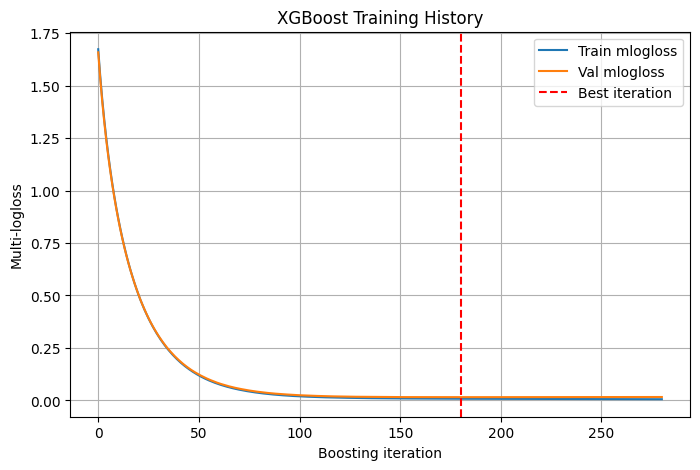

In [12]:
import matplotlib.pyplot as plt

train_loss = evals_result["train"]["mlogloss"]
val_loss   = evals_result["val"]["mlogloss"]

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train mlogloss")
plt.plot(val_loss, label="Val mlogloss")
plt.axvline(x=xgb_model.best_iteration, color="red", linestyle="--", label="Best iteration")
plt.xlabel("Boosting iteration")
plt.ylabel("Multi-logloss")
plt.title("XGBoost Training History")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_val,
        val_pred,
        target_names=le["classes"],
        zero_division=0,
        digits=4
    )
)

                          precision    recall  f1-score   support

Denial of Service Attack     1.0000    0.9601    0.9796       426
                 ipsweep     0.8654    0.9740    0.9165       231
                 neptune     0.9969    0.9999    0.9984      7080
                    nmap     1.0000    0.7636    0.8660       165
                  normal     0.9982    0.9992    0.9987     11848
               portsweep     0.9974    0.9948    0.9961       382
                   satan     0.9960    0.9881    0.9920       504
                   smurf     1.0000    0.9964    0.9982       274

                accuracy                         0.9961     20910
               macro avg     0.9817    0.9595    0.9682     20910
            weighted avg     0.9963    0.9961    0.9961     20910



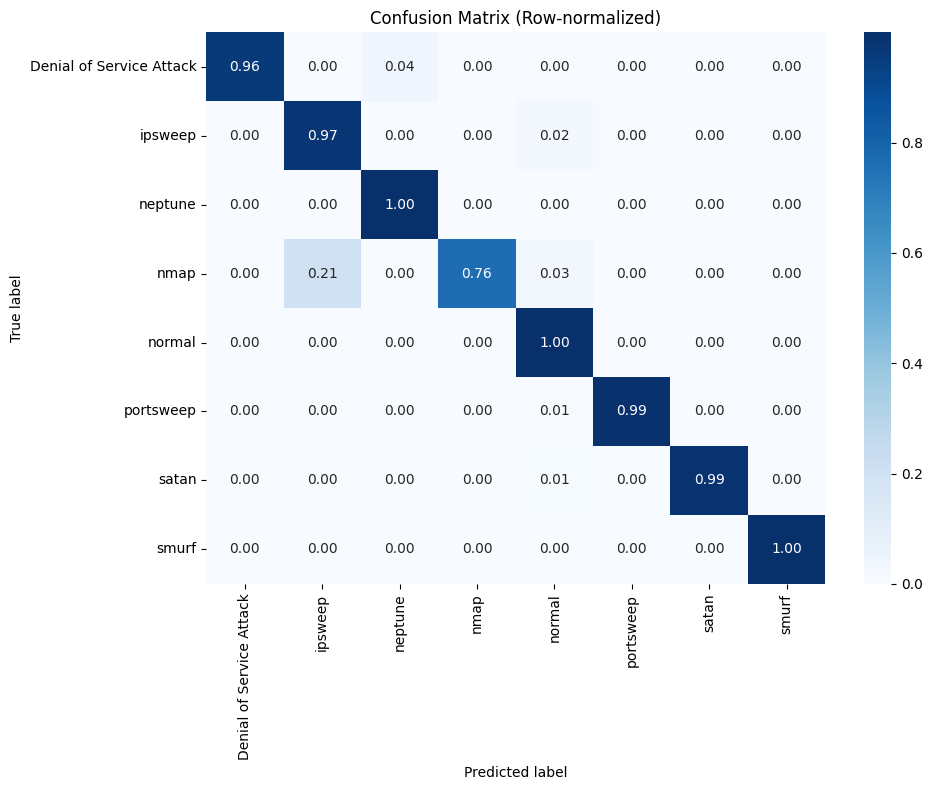

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, val_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm_norm,
    annot=True,            # <-- ini kuncinya
    fmt=".2f",             # 2 angka desimal
    cmap="Blues",
    xticklabels=le["classes"],
    yticklabels=le["classes"],
    cbar=True
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Row-normalized)")
plt.tight_layout()
plt.show()

In [15]:
OUT_DIR = Path("./models_xgb")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# save model
xgb_model.save_model(str(OUT_DIR / "xgb_model.json"))

# save validation predictions
np.save(OUT_DIR / "val_proba.npy", val_proba)
np.save(OUT_DIR / "val_pred.npy", val_pred)

# save metrics
metrics = {
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "best_iteration": int(xgb_model.best_iteration),
    "best_score_mlogloss": float(xgb_model.best_score),
    "params": params
}
with open(OUT_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved:", OUT_DIR / "xgb_model.json")
print("✅ Saved:", OUT_DIR / "metrics.json")

✅ Saved: models_xgb/xgb_model.json
✅ Saved: models_xgb/metrics.json


# M2 — CatBoost Training (multiclass)

In [16]:
try:
    from catboost import CatBoostClassifier, Pool
    import catboost
    print("catboost version:", catboost.__version__)
except Exception as e:
    print("catboost not available:", e)
    raise

catboost version: 1.2.8


In [17]:
# Pastikan dari setup Anda sudah punya:
# X_train_np, X_val_np, y_train, y_val, le

n_classes = len(le["classes"])

train_pool = Pool(X_train_np, label=y_train)
val_pool   = Pool(X_val_np, label=y_val)

params = {
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "iterations": 5000,
    "learning_rate": 0.05,
    "depth": 8,
    "l2_leaf_reg": 3.0,
    "random_seed": 42,
    "verbose": 200,
    "od_type": "Iter",
    "od_wait": 200,   # early stopping patience
    "task_type": "CPU"
}

In [18]:
cb_model = CatBoostClassifier(**params)
cb_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

best_iter = cb_model.get_best_iteration()
best_score = cb_model.get_best_score()
print("Best iteration:", best_iter)
print("Best score:", best_score)

0:	learn: 1.7650304	test: 1.7647242	best: 1.7647242 (0)	total: 300ms	remaining: 24m 59s
200:	learn: 0.0195452	test: 0.0249837	best: 0.0249489 (199)	total: 46s	remaining: 18m 18s
400:	learn: 0.0142380	test: 0.0183173	best: 0.0183173 (400)	total: 1m 27s	remaining: 16m 47s
600:	learn: 0.0119452	test: 0.0159284	best: 0.0159284 (600)	total: 2m 11s	remaining: 16m
800:	learn: 0.0104812	test: 0.0149495	best: 0.0149460 (794)	total: 2m 56s	remaining: 15m 26s
1000:	learn: 0.0094964	test: 0.0144787	best: 0.0144729 (984)	total: 3m 42s	remaining: 14m 49s
1200:	learn: 0.0087622	test: 0.0142868	best: 0.0142845 (1198)	total: 4m 28s	remaining: 14m 9s
1400:	learn: 0.0081772	test: 0.0140686	best: 0.0140674 (1398)	total: 5m 14s	remaining: 13m 27s
1600:	learn: 0.0076901	test: 0.0139210	best: 0.0139210 (1600)	total: 6m	remaining: 12m 44s
1800:	learn: 0.0072909	test: 0.0138697	best: 0.0138590 (1791)	total: 6m 46s	remaining: 12m 1s
2000:	learn: 0.0069331	test: 0.0138404	best: 0.0138282 (1991)	total: 7m 32s	rem

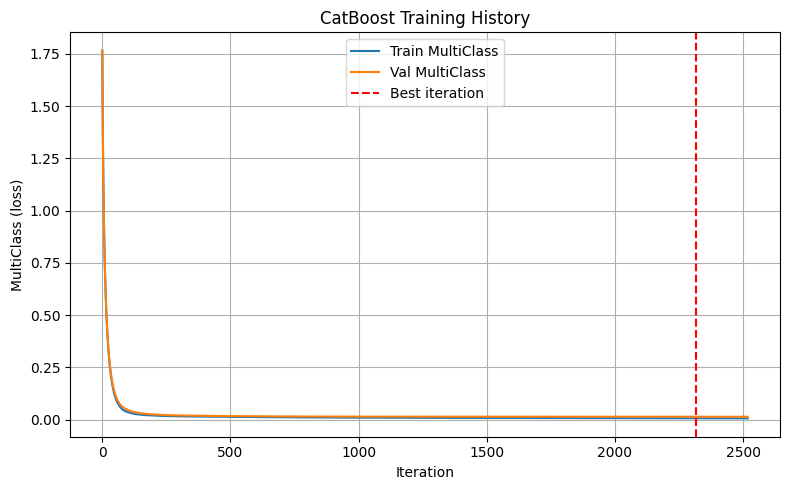

In [19]:
import matplotlib.pyplot as plt

evals = cb_model.get_evals_result()

# CatBoost biasanya menyimpan "MultiClass" sebagai metric
train_metric = evals["learn"]["MultiClass"]
val_metric   = evals["validation"]["MultiClass"]

plt.figure(figsize=(8,5))
plt.plot(train_metric, label="Train MultiClass")
plt.plot(val_metric, label="Val MultiClass")
plt.axvline(x=best_iter, color="red", linestyle="--", label="Best iteration")
plt.xlabel("Iteration")
plt.ylabel("MultiClass (loss)")
plt.title("CatBoost Training History")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np
import pandas as pd
import seaborn as sns

val_proba = cb_model.predict_proba(val_pool)
val_pred = np.argmax(val_proba, axis=1)

macro_f1 = f1_score(y_val, val_pred, average="macro")
weighted_f1 = f1_score(y_val, val_pred, average="weighted")

print("CatBoost Results")
print("macro-F1   :", macro_f1)
print("weighted-F1:", weighted_f1)

print("\nClassification Report:\n")
print(classification_report(y_val, val_pred, target_names=le["classes"], digits=4, zero_division=0))

CatBoost Results
macro-F1   : 0.967281411383458
weighted-F1: 0.9959725409582018

Classification Report:

                          precision    recall  f1-score   support

Denial of Service Attack     1.0000    0.9624    0.9809       426
                 ipsweep     0.8755    0.9437    0.9083       231
                 neptune     0.9986    0.9999    0.9992      7080
                    nmap     0.9704    0.7939    0.8733       165
                  normal     0.9976    0.9992    0.9984     11848
               portsweep     0.9845    0.9974    0.9909       382
                   satan     0.9940    0.9841    0.9890       504
                   smurf     1.0000    0.9964    0.9982       274

                accuracy                         0.9960     20910
               macro avg     0.9776    0.9596    0.9673     20910
            weighted avg     0.9961    0.9960    0.9960     20910



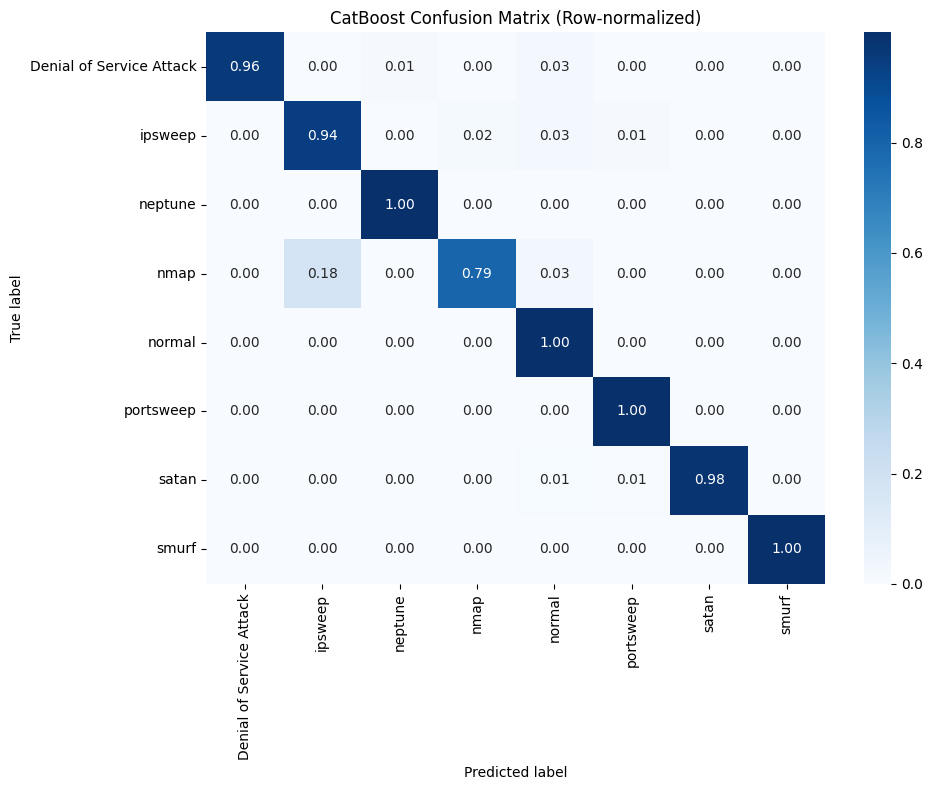

In [21]:
cm = confusion_matrix(y_val, val_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=le["classes"],
    yticklabels=le["classes"],
    cbar=True
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CatBoost Confusion Matrix (Row-normalized)")
plt.tight_layout()
plt.show()

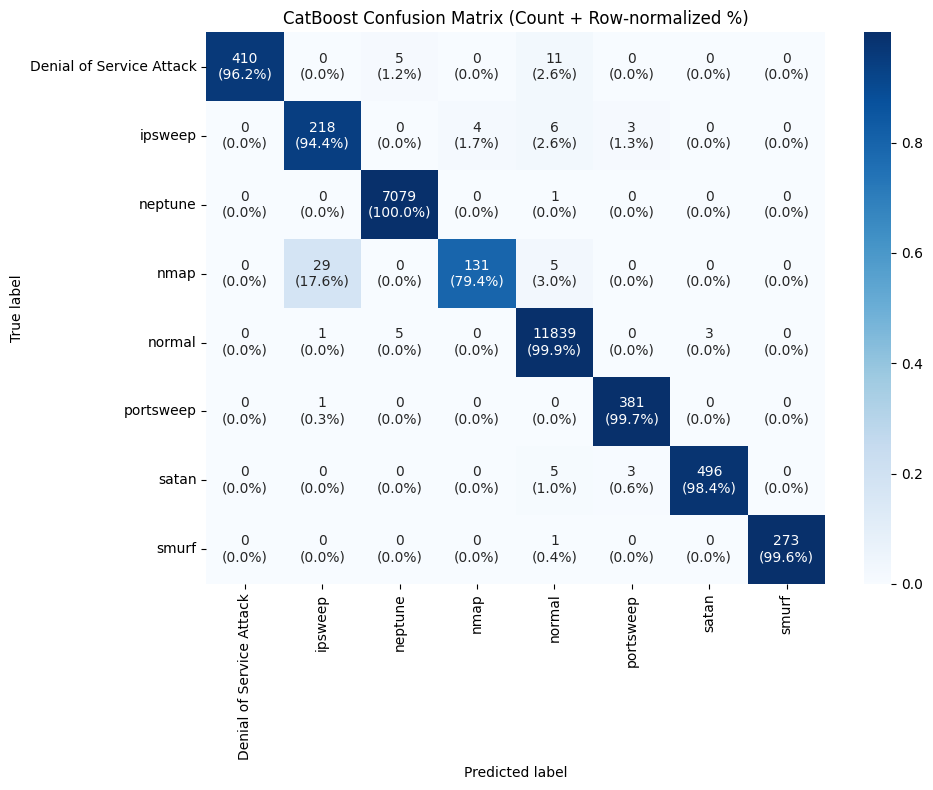

In [22]:
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)"

plt.figure(figsize=(10,8))
sns.heatmap(
    cm_norm,
    annot=annot,
    fmt="",
    cmap="Blues",
    xticklabels=le["classes"],
    yticklabels=le["classes"],
    cbar=True
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CatBoost Confusion Matrix (Count + Row-normalized %)")
plt.tight_layout()
plt.show()

In [23]:
import json
from pathlib import Path

OUT_DIR = Path("./models_catboost")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# save model
cb_model.save_model(str(OUT_DIR / "catboost_model.cbm"))

# save preds
np.save(OUT_DIR / "val_proba.npy", val_proba)
np.save(OUT_DIR / "val_pred.npy", val_pred)

# save metrics
metrics = {
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "best_iteration": int(best_iter),
    "best_score": best_score,
    "params": params
}
with open(OUT_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved:", OUT_DIR / "catboost_model.cbm")
print("✅ Saved:", OUT_DIR / "metrics.json")

✅ Saved: models_catboost/catboost_model.cbm
✅ Saved: models_catboost/metrics.json


# M3 - MLP

In [24]:
import os, random, json
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Pastikan sudah ada dari setup:
# X_train_np, X_val_np, y_train, y_val, le
n_classes = len(le["classes"])

print("X_train_np:", X_train_np.shape, X_train_np.dtype)
print("n_classes:", n_classes)

2026-01-11 08:02:47.921706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768118568.104650      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768118568.162903      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768118568.608317      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768118568.608353      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768118568.608357      24 computation_placer.cc:177] computation placer alr

X_train_np: (90129, 196) float32
n_classes: 8


In [25]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.arange(n_classes)
class_weights_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, class_weights_arr)}

# cek beberapa
print("Example class_weight:", list(class_weight.items())[:10])

Example class_weight: [(0, 8.534943181818182), (1, 4.01644385026738), (2, 0.3786678206507126), (3, 9.737359550561798), (4, 0.23315173527037933), (5, 4.965237990304098), (6, 4.692263640149937), (7, 5.354622148288973)]


In [26]:
from tensorflow import keras
from tensorflow.keras import layers

def build_mlp(input_dim, n_classes):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inputs)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

model = build_mlp(X_train_np.shape[1], n_classes)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

I0000 00:00:1768118581.122160      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 196)            │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        50,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,888 (362.84 KB)

 Trainable params: 92,496 (361.31 KB)

 Non-trainable params: 392 (1.53 KB)

Epoch 1/200


I0000 00:00:1768118584.600022      90 service.cc:152] XLA service 0x7881a000c7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768118584.600056      90 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768118584.974859      90 cuda_dnn.cc:529] Loaded cuDNN version 91002


 64/353 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4658 - loss: 1.4087

I0000 00:00:1768118587.355639      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7780 - loss: 0.6776 - val_accuracy: 0.9797 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 2/200
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.1914 - val_accuracy: 0.9783 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 3/200
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9709 - loss: 0.1602 - val_accuracy: 0.9856 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 4/200
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.1524 - val_accuracy: 0.9895 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 5/200
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9781 - loss: 0.1381 - val_accuracy: 0.9915 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 6/200
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9795 - loss: 0.1340 - val_accuracy: 0.9895 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 7/200
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9801 - loss: 0.1310 - val_

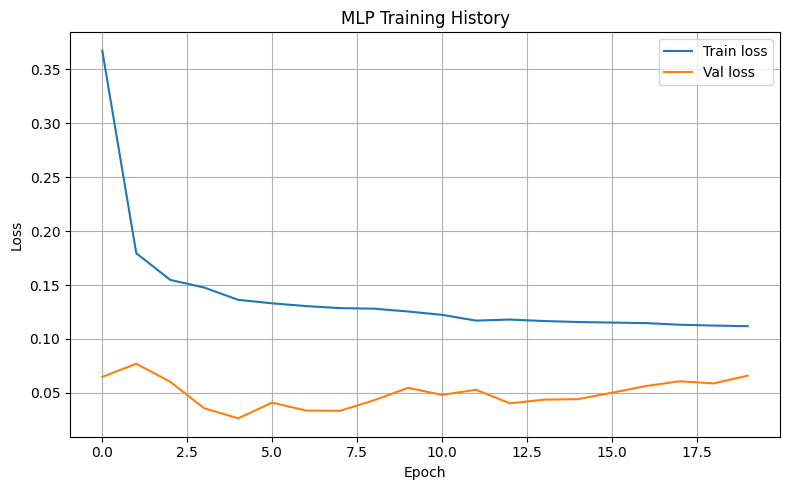

In [27]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=6,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=200,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

# Plot training history (loss)
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Training History")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
val_proba = model.predict(X_val_np, verbose=0)
val_pred = np.argmax(val_proba, axis=1)

macro_f1 = f1_score(y_val, val_pred, average="macro")
weighted_f1 = f1_score(y_val, val_pred, average="weighted")

print("MLP Results")
print("macro-F1   :", macro_f1)
print("weighted-F1:", weighted_f1)

print("\nClassification Report:\n")
print(classification_report(y_val, val_pred, target_names=le["classes"], digits=4, zero_division=0))

MLP Results
macro-F1   : 0.9441003829201564
weighted-F1: 0.9916731604350844

Classification Report:

                          precision    recall  f1-score   support

Denial of Service Attack     0.9610    0.9836    0.9722       426
                 ipsweep     0.8440    0.7965    0.8196       231
                 neptune     0.9987    0.9989    0.9988      7080
                    nmap     0.7536    0.9636    0.8457       165
                  normal     0.9990    0.9920    0.9955     11848
               portsweep     0.9548    0.9948    0.9744       382
                   satan     0.9481    0.9782    0.9629       504
                   smurf     0.9715    0.9964    0.9838       274

                accuracy                         0.9915     20910
               macro avg     0.9288    0.9630    0.9441     20910
            weighted avg     0.9921    0.9915    0.9917     20910



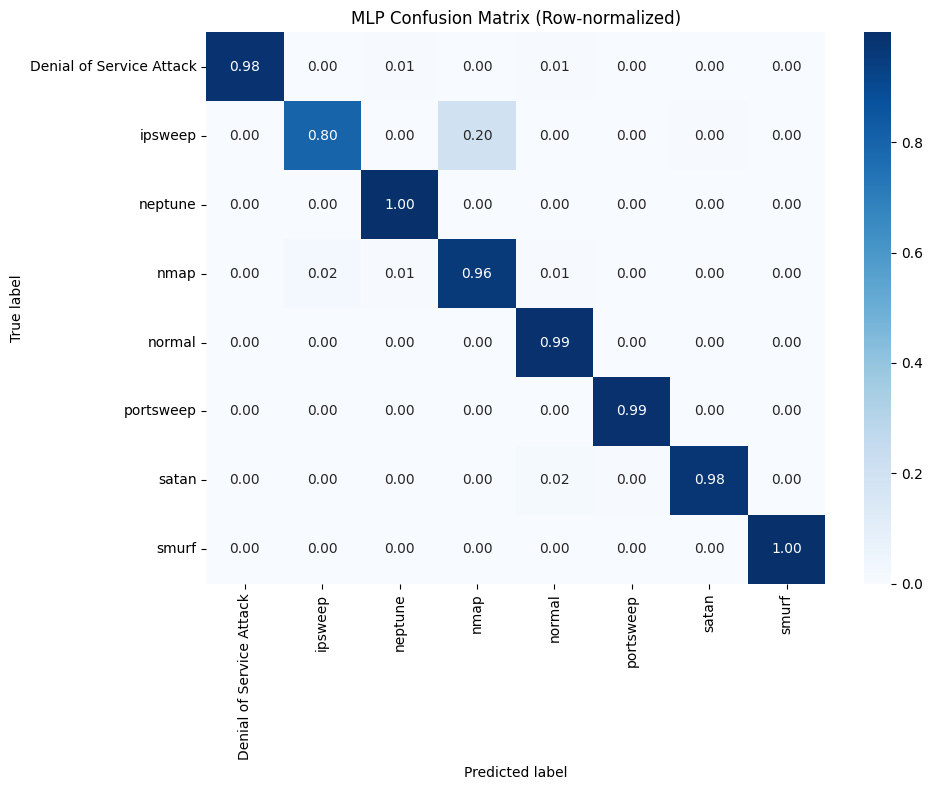

In [29]:
cm = confusion_matrix(y_val, val_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=le["classes"],
    yticklabels=le["classes"],
    cbar=True
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("MLP Confusion Matrix (Row-normalized)")
plt.tight_layout()
plt.show()

In [30]:
from pathlib import Path

OUT_DIR = Path("./models_mlp")
OUT_DIR.mkdir(exist_ok=True, parents=True)

model.save(OUT_DIR / "mlp_model.keras")

np.save(OUT_DIR / "val_proba.npy", val_proba)
np.save(OUT_DIR / "val_pred.npy", val_pred)

metrics = {
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "epochs_ran": int(len(history.history["loss"])),
    "best_val_loss": float(np.min(history.history["val_loss"])),
    "batch_size": 256,
    "lr": 1e-3
}
with open(OUT_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved:", OUT_DIR / "mlp_model.keras")
print("✅ Saved:", OUT_DIR / "metrics.json")

✅ Saved: models_mlp/mlp_model.keras
✅ Saved: models_mlp/metrics.json


# M4 - Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,                 # bisa diganti 20/30 kalau overfit
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_np, y_train)
print("✅ RF training done.")

✅ RF training done.


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

val_pred = rf.predict(X_val_np)

macro_f1 = f1_score(y_val, val_pred, average="macro")
weighted_f1 = f1_score(y_val, val_pred, average="weighted")

print("Random Forest Results")
print("macro-F1   :", macro_f1)
print("weighted-F1:", weighted_f1)

print("\nClassification Report:\n")
print(classification_report(y_val, val_pred, target_names=le["classes"], digits=4, zero_division=0))

Random Forest Results
macro-F1   : 0.9573665944107479
weighted-F1: 0.9951185958056109

Classification Report:

                          precision    recall  f1-score   support

Denial of Service Attack     1.0000    0.9531    0.9760       426
                 ipsweep     0.8242    0.9740    0.8929       231
                 neptune     0.9980    1.0000    0.9990      7080
                    nmap     1.0000    0.6788    0.8087       165
                  normal     0.9971    0.9992    0.9982     11848
               portsweep     0.9948    0.9974    0.9961       382
                   satan     0.9980    0.9821    0.9900       504
                   smurf     1.0000    0.9964    0.9982       274

                accuracy                         0.9953     20910
               macro avg     0.9765    0.9476    0.9574     20910
            weighted avg     0.9956    0.9953    0.9951     20910



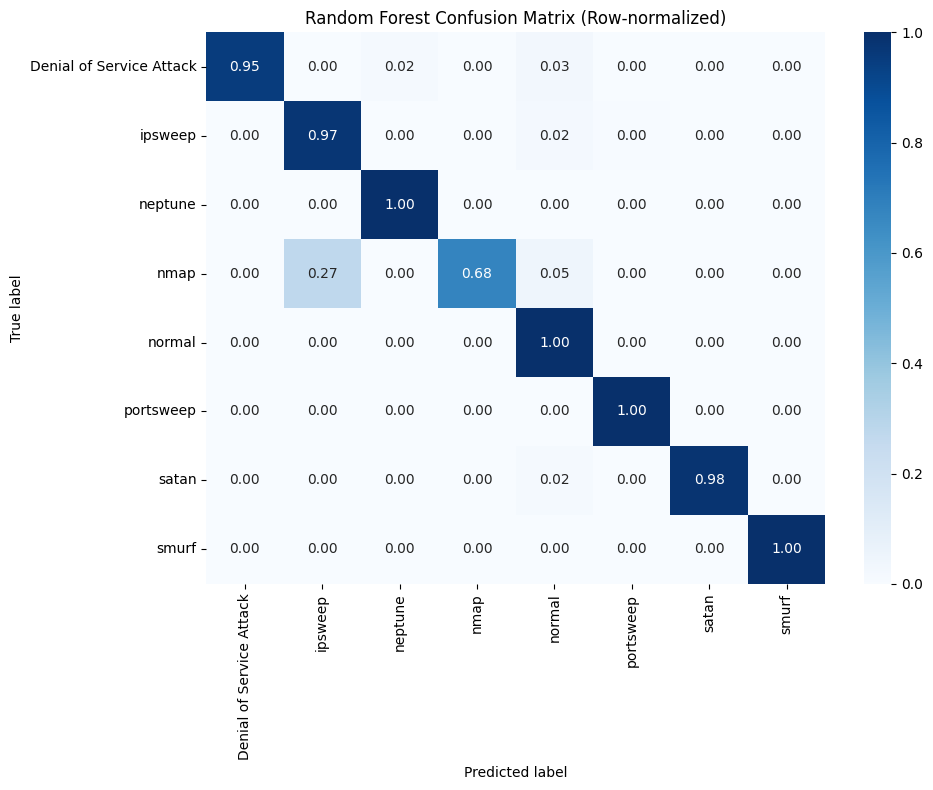

In [33]:
cm = confusion_matrix(y_val, val_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=le["classes"],
    yticklabels=le["classes"],
    cbar=True
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Random Forest Confusion Matrix (Row-normalized)")
plt.tight_layout()
plt.show()

In [34]:
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

print("Top 30 feature importances:")
display(importances.head(30))

Top 30 feature importances:


src_bytes                                           0.068860
srv_count                                           0.065587
dst_host_srv_count                                  0.061137
dst_host_count                                      0.057599
count                                               0.043432
service_ecr_i                                       0.042066
dst_host_same_src_port_rate                         0.033991
protocol_type_icmp                                  0.031975
dst_host_diff_srv_rate                              0.030848
dst_host_same_srv_rate                              0.026276
dst_host_serror_rate                                0.026262
dst_bytes                                           0.024010
flag_s0                                             0.023415
is_nonzero__rerror_rate                             0.021585
wrong_fragment                                      0.021531
is_nonzero__wrong_fragment                          0.020860
__group_id__            

In [35]:
import json
import joblib
from pathlib import Path

OUT_DIR = Path("./models_rf")
OUT_DIR.mkdir(exist_ok=True, parents=True)

joblib.dump(rf, OUT_DIR / "rf_model.joblib")
np.save(OUT_DIR / "val_pred.npy", val_pred)

metrics = {
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "n_estimators": 600,
    "max_depth": None,
    "class_weight": "balanced_subsample"
}
with open(OUT_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved:", OUT_DIR / "rf_model.joblib")
print("✅ Saved:", OUT_DIR / "metrics.json")

✅ Saved: models_rf/rf_model.joblib
✅ Saved: models_rf/metrics.json


# M5 - Summary

In [36]:
import json
import pandas as pd
from pathlib import Path

MODEL_DIRS = {
    "XGBoost": Path("./models_xgb/metrics.json"),
    "CatBoost": Path("./models_catboost/metrics.json"),
    "MLP": Path("./models_mlp/metrics.json"),
    "Random Forest": Path("./models_rf/metrics.json"),
}

rows = []
for model_name, path in MODEL_DIRS.items():
    with open(path, "r") as f:
        m = json.load(f)

    rows.append({
        "Model": model_name,
        "Macro-F1": m.get("macro_f1"),
        "Weighted-F1": m.get("weighted_f1"),
    })

df_perf = pd.DataFrame(rows).sort_values("Macro-F1", ascending=False)
df_perf

,Model,Macro-F1,Weighted-F1
0,XGBoost,0.968188,0.996051
1,CatBoost,0.967281,0.995973
3,Random Forest,0.957367,0.995119
2,MLP,0.944100,0.991673


In [37]:
def highlight_best(s):
    is_best = s == s.max()
    return ["background-color: #c6f5c6; font-weight: bold" if v else "" for v in is_best]

styled = (
    df_perf
    .style
    .format({"Macro-F1": "{:.4f}", "Weighted-F1": "{:.4f}"})
    .apply(highlight_best, subset=["Macro-F1"])
)

styled

,Model,Macro-F1,Weighted-F1
0,XGBoost,0.9682,0.9961
1,CatBoost,0.9673,0.9960
3,Random Forest,0.9574,0.9951
2,MLP,0.9441,0.9917
